In [1]:
# Import dependencies
from scipy.io import wavfile
from sklearn.svm import SVC
from scipy.signal import spectrogram
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from pathlib import Path

import glob
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import random
#assert tf.__version__ == "1.7.0"
#tf.logging.set_verbosity(tf.logging.INFO)


In [2]:
dataset = [{'path': path, 'label': path.split('/' )[4] } for path in glob.glob("../../dataset_heart_sound/MV/**/*.wav")]
df = pd.DataFrame.from_dict(dataset)
print(dataset[0])

# Add a column to store the data read from each wavfile...   
df['x'] = df['path'].apply(lambda x: wavfile.read(x)[1])
df.head()

{'path': '../../dataset_heart_sound/MV/abnormal/39403_MV.wav', 'label': 'abnormal'}


,path,label,x
0,../../dataset_heart_sound/MV/abnormal/39403_MV...,abnormal,"[-52, 1425, 1425, 679, 996, 1060, 832, 773, 73..."
1,../../dataset_heart_sound/MV/abnormal/50123_MV...,abnormal,"[204, 196, 727, 1239, 1039, 1170, 1225, 1042, ..."
2,../../dataset_heart_sound/MV/abnormal/68298_MV...,abnormal,"[350, 726, 1021, 522, -157, -7, 460, 298, 140,..."
3,../../dataset_heart_sound/MV/abnormal/78582_MV...,abnormal,"[20568, 10910, 1994, -1721, 153, 61, -923, -33..."
4,../../dataset_heart_sound/MV/abnormal/68895_MV...,abnormal,"[-24689, -23281, -20237, -11313, -4349, -1444,..."


# Sample class audio plot 

Displaying all three kinds of audio classes normal, abnormal and extrasystole. We can see different patters in various classes.


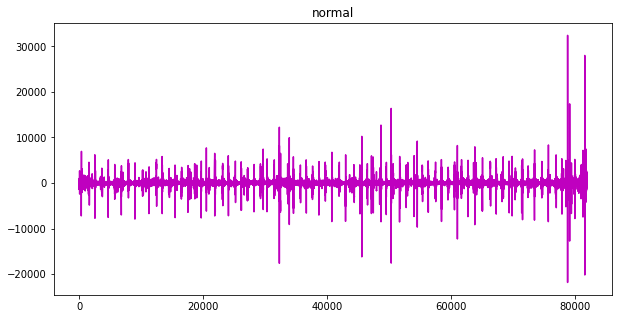

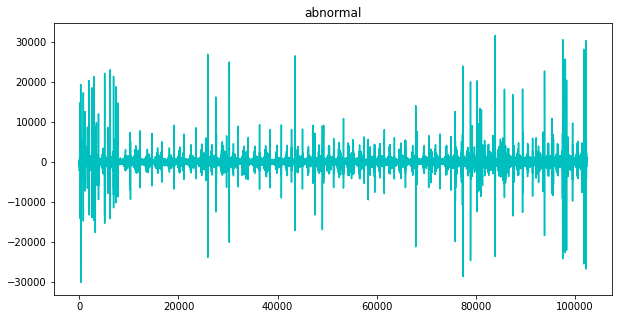

In [3]:
#Choosing one of the each samples form each catogery 
normal = df[df['label'] == 'normal' ].sample(1)
abnormal = df[df['label'] == 'abnormal' ].sample(1)
#extrasystole = df[df['label'] == 'extsys' ].sample(1)

# Plot the three samples onto three different figures
plt.figure(1, figsize=(10,5))
plt.title('normal')
plt.plot(normal['x'].values[0], c='m')

plt.figure(2, figsize=(10, 5))
plt.title('abnormal')
plt.plot(abnormal['x'].values[0], c='c')

#plt.figure(3, figsize=(10, 5))
#plt.title('extrasystole')
#plt.plot(extrasystole['x'].values[0], c='b')

In [4]:
#make the lenght of all audio files same by repeating audio file contents till its length is equal to max length audio file
max_length = max(df['x'].apply(len))

# Kaggle: What's in a heartbeat? - Peter Grenholm
def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = np.float32)
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

df['x'] = df['x'].apply(repeat_to_length, length=max_length)
df.head()

,path,label,x
0,../../dataset_heart_sound/MV/abnormal/39403_MV...,abnormal,"[-52.0, 1425.0, 1425.0, 679.0, 996.0, 1060.0, ..."
1,../../dataset_heart_sound/MV/abnormal/50123_MV...,abnormal,"[204.0, 196.0, 727.0, 1239.0, 1039.0, 1170.0, ..."
2,../../dataset_heart_sound/MV/abnormal/68298_MV...,abnormal,"[350.0, 726.0, 1021.0, 522.0, -157.0, -7.0, 46..."
3,../../dataset_heart_sound/MV/abnormal/78582_MV...,abnormal,"[20568.0, 10910.0, 1994.0, -1721.0, 153.0, 61...."
4,../../dataset_heart_sound/MV/abnormal/68895_MV...,abnormal,"[-24689.0, -23281.0, -20237.0, -11313.0, -4349..."


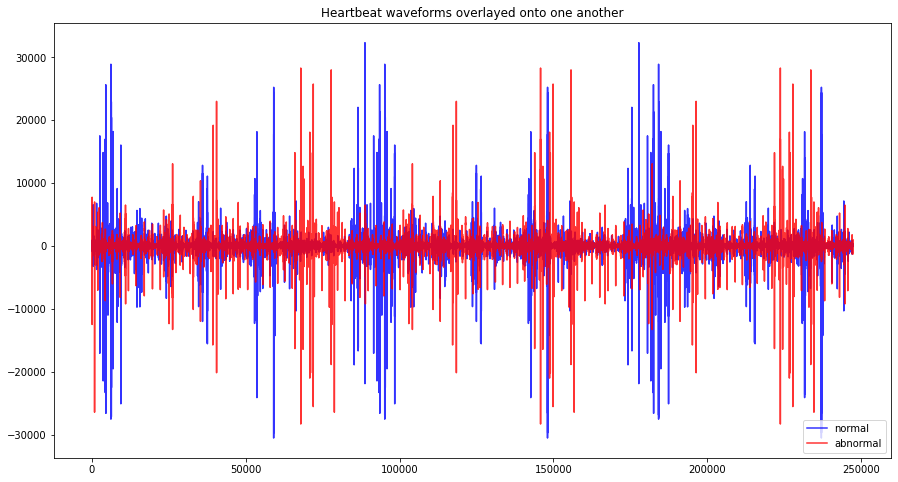

In [5]:
# Collect one sample from each of the three classes and plot their waveforms
normal = df[df['label'] == 'normal' ].sample(1)
abnormal = df[df['label'] == 'abnormal' ].sample(1)
#extrasystole = df[df['label'] == 'extsys' ].sample(1)

plt.figure(1, figsize=(15,8))
plt.plot(normal['x'].values[0], c='b', label='normal', alpha=0.8)
plt.plot(abnormal['x'].values[0], c='r', label='abnormal', alpha=0.8)
#plt.plot(extrasystole['x'].values[0], c='g', label='extrasystole', alpha=0.8)

plt.title('Heartbeat waveforms overlayed onto one another')
plt.legend(loc='lower right')
# plt.savefig('temp.png')

"\nf_extra, t_extra, Sxx_extra = spectrogram(extrasystole['x'].values[0], 4000)\nplt.figure(3, figsize=(20, 5))\nplt.title('Extrasystole')\nplt.pcolormesh(t_extra, f_extra, Sxx_extra, cmap='Spectral')\nplt.ylabel('Frequency [Hz]')\nplt.xlabel('Time [sec]')\n"

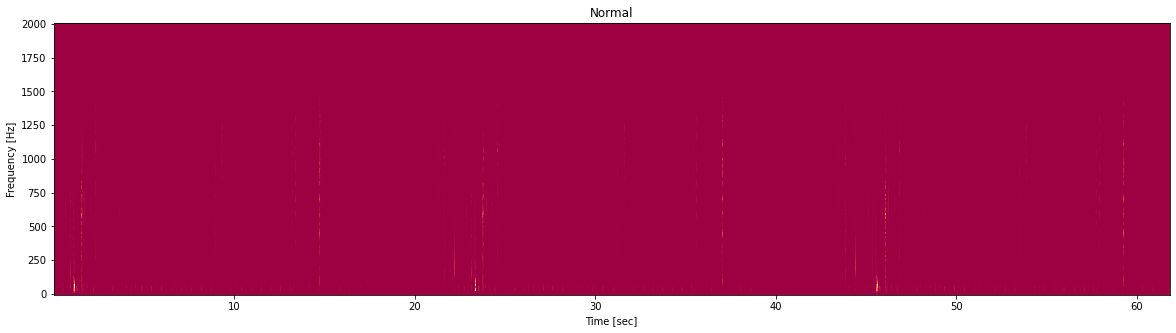

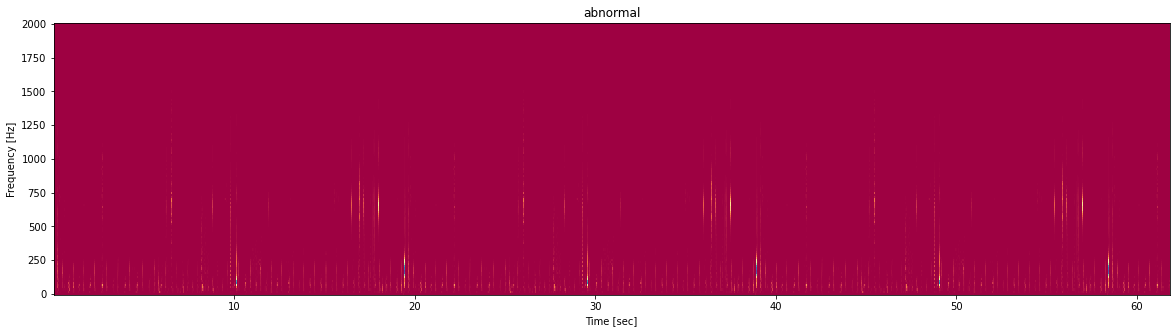

In [6]:
fs = 4000
f_normal, t_normal, Sxx_normal = spectrogram(normal['x'].values[0], 4000)
plt.figure(1, figsize=(20,5))
plt.title('Normal')
plt.pcolormesh(t_normal, f_normal, Sxx_normal, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

f_abnormal, t_abnormal, Sxx_abnormal = spectrogram(abnormal['x'].values[0], 4000)
plt.figure(2, figsize=(20, 5))
plt.title('abnormal')
plt.pcolormesh(t_abnormal, f_abnormal, Sxx_abnormal, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

"""
f_extra, t_extra, Sxx_extra = spectrogram(extrasystole['x'].values[0], 4000)
plt.figure(3, figsize=(20, 5))
plt.title('Extrasystole')
plt.pcolormesh(t_extra, f_extra, Sxx_extra, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
"""

In [7]:
# Put the data into numpy arrays. Most machine learning libraries use numpy arrays.
x = np.stack(df['x'].values, axis=0)
y = np.stack(df['label'].values, axis=0)

In [8]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test, train_filenames, test_filenames = train_test_split(x, df['label'].values, df['path'].values, train_size = 0.4, test_size=0.2)
print("x_train: {0}, x_test: {1}".format(x_train.shape, x_test.shape))

x_train = x_train[:, 30000:100000]

x_test = x_test[:, 30000:100000]

print("x_train: {0}, x_test: {1}".format(x_train.shape, x_test.shape))

x_train: (339, 247360), x_test: (170, 247360)
x_train: (339, 70000), x_test: (170, 70000)


In [9]:
clf = SVC()


In [10]:
clf.fit(x_train, y_train)


SVC()

In [11]:
predictions = clf.predict(x_test)
print("Accuracy %.3f" % accuracy_score(y_test, predictions))

Accuracy 0.565


In [12]:
clf = MLPClassifier(hidden_layer_sizes=(1024,512,256,128,), 
                    max_iter=5000, verbose=True)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print("Accuracy %.3f" % accuracy_score(y_test, predictions))

Iteration 1, loss = 8.20371701
Iteration 2, loss = 4.75597060
Iteration 3, loss = 0.99566791
Iteration 4, loss = 1.42943865
Iteration 5, loss = 0.75366482
Iteration 6, loss = 0.14236982
Iteration 7, loss = 0.00134614
Iteration 8, loss = 0.09545472
Iteration 9, loss = 0.14252927
Iteration 10, loss = 0.00148704
Iteration 11, loss = 0.09557770
Iteration 12, loss = 0.00155265
Iteration 13, loss = 0.00157847
Iteration 14, loss = 0.00160037
Iteration 15, loss = 0.00161891
Iteration 16, loss = 0.00163453
Iteration 17, loss = 0.04867534
Iteration 18, loss = 0.00165866
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy 0.482


In [13]:
# Convert data to the format tf.keras expects
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]
x_train.shape

(339, 70000, 1)

# CNN Model

In [14]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=9, activation='relu',
                input_shape = x_train.shape[1:]))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.GlobalAvgPool1D())
model.add(tf.keras.layers.Dense(2, activation='softmax'))

2022-09-02 01:46:55.801312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 01:46:55.807849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 01:46:55.808206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 01:46:55.809209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [16]:
# Need to convert y labels into one-hot encoded vectors
y_train_int_categories, y_train_class_names = pd.factorize(y_train)
print("y_train_class_names: {0}".format(y_train_class_names))

y_test_int_categories, y_test_class_names = pd.factorize(y_test)
print("y_test_class_names: {0}".format(y_test_class_names))
y_train_hot = tf.keras.utils.to_categorical(y_train_int_categories)
y_test_hot = tf.keras.utils.to_categorical(y_test_int_categories)

hist = model.fit(x_train, y_train_hot, 
                 epochs=50,
                 validation_data=(x_test, y_test_hot), verbose=1)

y_train_class_names: ['normal' 'abnormal']
y_test_class_names: ['normal' 'abnormal']
Epoch 1/50


2022-09-02 01:46:58.608708: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


11/11 [==============================] - 3s 61ms/step - loss: 0.7636 - accuracy: 0.4867 - val_loss: 0.7009 - val_accuracy: 0.4765
Epoch 2/50
11/11 [==============================] - 0s 20ms/step - loss: 0.7215 - accuracy: 0.5634 - val_loss: 0.7245 - val_accuracy: 0.4647
Epoch 3/50
11/11 [==============================] - 0s 22ms/step - loss: 0.6753 - accuracy: 0.5752 - val_loss: 0.7295 - val_accuracy: 0.4647
Epoch 4/50
11/11 [==============================] - 0s 20ms/step - loss: 0.7303 - accuracy: 0.5280 - val_loss: 0.7443 - val_accuracy: 0.4647
Epoch 5/50
11/11 [==============================] - 0s 20ms/step - loss: 0.7059 - accuracy: 0.5457 - val_loss: 0.7441 - val_accuracy: 0.4647
Epoch 6/50
11/11 [==============================] - 0s 20ms/step - loss: 0.7124 - accuracy: 0.5428 - val_loss: 0.7475 - val_accuracy: 0.4647
Epoch 7/50
11/11 [==============================] - 0s 20ms/step - loss: 0.6974 - accuracy: 0.5870 - val_loss: 0.7532 - val_accuracy: 0.4647
Epoch 8/50
11/11 [======

# Plot of accuracy and loss

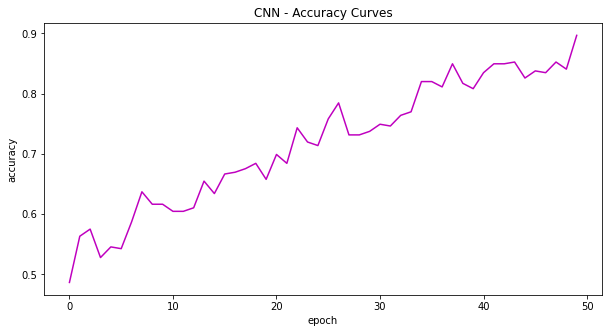

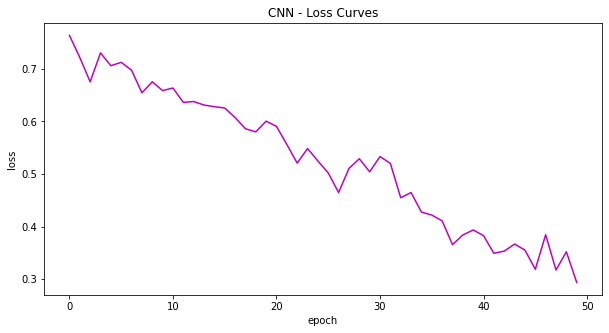

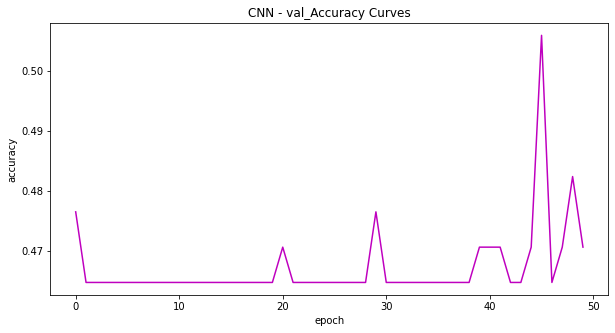

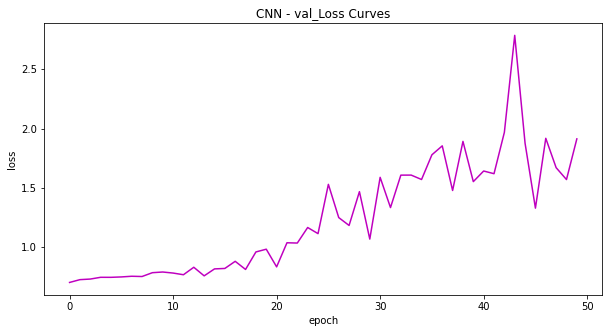

In [17]:
accuracy = hist.history['accuracy']
loss = hist.history['loss']
val_accuracy = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

plt.figure(1, figsize=(10, 5))
plt.title('CNN - Accuracy Curves')
plt.plot(accuracy, c='m')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.figure(2, figsize=(10, 5))
plt.title('CNN - Loss Curves')
plt.plot(loss, c='m')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure(3, figsize=(10, 5))
plt.title('CNN - val_Accuracy Curves')
plt.plot(val_accuracy, c='m')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.figure(4, figsize=(10, 5))
plt.title('CNN - val_Loss Curves')
plt.plot(val_loss, c='m')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()


In [18]:
import time
start = time.time()*1000
model.predict(x_test)
end = time.time()*1000
total = end - start
print("Total prediction time (milliseconds) for %d samples: %f" % (len(x_test), total))
print("Average prediction time for one example: %f" % (total/len(x_test)))

6/6 [==============================] - 0s 5ms/step
Total prediction time (milliseconds) for 170 samples: 301.682617
Average prediction time for one example: 1.774604


In [19]:
# Save the train model
tf.keras.models.save_model(
    model,
    filepath='C:/Users/apt/Desktop/save_model',
    overwrite=True,
    include_optimizer=True
)

INFO:tensorflow:Assets written to: C:/Users/apt/Desktop/save_model/assets


INFO:tensorflow:Assets written to: C:/Users/apt/Desktop/save_model/assets


: 